# Parallelizing the `for` loop

Manual matrix inversion and sparsity have led to great performance gains, but more can be accomplished. Perhaps the greatest source of potential is the single `for` loop that runs through each line in the network. There is no need for one process to handle every line in series, but the way the code is currently written precludes parallelization.

I begin the re-write by deleting old versions of the temporal instanton code. One of the greatest things about version control is that you don't need to be sentimental.

The files `TemporalInstanton3` and `PowerFlow` are the only ones I currrently use. Everything else contains duplicate or inferior code.

Can you parallelize a `for` loop when each loop accesses a common variable? **Yes, but there's no need to. Better to use a parallel `for` loop with `vcat` reduction operator.**

## pmap

In [66]:
addprocs(4)

4-element Array{Any,1}:
 2
 3
 4
 5

In [71]:
@everywhere f(x) = "number $x"
x = [i for i in 1:5]
@time pmap(f,x); # parallel
@time [f(i) for i in x]; # single-core

elapsed time: 0.003637451 seconds (32584 bytes allocated)
elapsed time: 3.0018e-5 seconds (2416 bytes allocated)


5-element Array{Union(UTF8String,ASCIIString),1}:
 "number 1"
 "number 2"
 "number 3"
 "number 4"
 "number 5"

## pmap and custom types

In [8]:
@everywhere type InstantonInput
    field1
    field2
end

outside_data = 1
@everywhere function analyze(x)
    println(x.field2)
    return x.field1[1] + x.field1[2] + outside_data,x.field1
end
x = [InstantonInput([i,i+1],"$i") for i in 1:4]
results1,results2 = pmap(analyze,x); # parallel

Parallel version is faster (but takes more space). Great! So this is what I'm supposed to do. I can start with an array of empty vectors and fill each with an instanton solution.

## @parallel `for` and `SharedArray`

In [72]:
# works!
solutions = SharedArray(Int64,4)
@time @sync @parallel for i = 1:4
    solutions[i] = i;
end
solutions

elapsed time: 0.473257131 seconds (7873240 bytes allocated)


4-element SharedArray{Int64,1}:
 1
 2
 3
 4

In [73]:
# works!
# solutions = SharedArray(Int64,4)
results = @time @sync @parallel (vcat) for i = 1:4
    [i;i+1],i+2
end

elapsed time: 1.027511758 seconds (13558608 bytes allocated)


4-element Array{(Array{Int64,1},Int64),1}:
 ([1,2],3)
 ([2,3],4)
 ([3,4],5)
 ([4,5],6)

In [ ]:
rmprocs(workers())

## New approach

The `for` loop is one way to look at temporal instanton analysis. Another way to look at it is a function that accepts a set of matrices, solves a QCQP, and returns a solution vector. If I want to apply this function to each line, I need only build the matrices for all lines and use `pmap` to apply the instanton function to each line's set in parallel.

** UPDATE (2015-07-27): pmap is not feasible. Better to use a parallel `for` loop with `vcat` reduction operator. No need for `SharedArray`.**

## Winning approach

I tried the `pmap` approach and found it rather awkward. It was difficult to distribute "global" variables. I kept getting "x is undefined" kinds of messages. So I went back to the parallel for loop.



## Results

In [ ]:
# Analysis:
addprocs(4) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

# Thermal model parameters:
Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp

In [4]:
@time score,x,θ,α,diffs,xopt = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length);

elapsed time: 13.072046053 seconds (5274097432 bytes allocated, 30.95% gc time)


* 0 proc: 13.0 seconds,  5.3 GB
* 1 proc:  9.2 seconds, 30.0 MB
* 2 procs: 6.0 seconds, 43.6 MB
* 3 procs: 6.4 seconds, 56.2 MB
* 4 procs: 5.5 seconds, 68.9 MB
* 5 procs: 5.7 seconds, 81.6 MB
* 6 procs: 5.6 seconds, 94.3 MB

In [6]:
using PyPlot
PyPlot.svg(true)

numProcs = [0:6]
calcTime = [13.0;9.2;6.0;6.4;5.5;5.7;5.6]
alloc = [5.3e9,30e6,43.6e6,56.2e6,68.9e6,81.6e6,94.3e6]

# Throw out 0-proc case. Way too slow, and huge allocation!
# not even worth plotting
numProcs = numProcs[2:end]
calcTime = calcTime[2:end]
alloc = alloc[2:end]

INFO: Loading help data...


7-element Array{Float64,1}:
 5.3e9 
 3.0e7 
 4.36e7
 5.62e7
 6.89e7
 8.16e7
 9.43e7

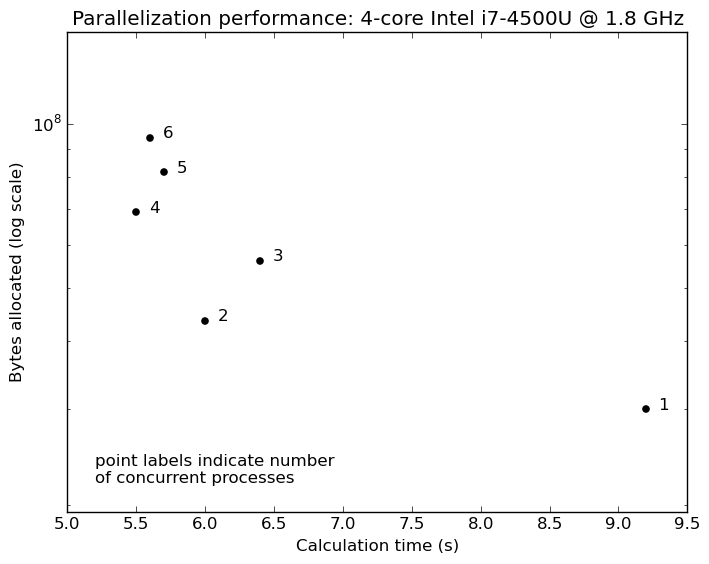

In [65]:
scatter(calcTime,alloc,color="k")
#xscale("log")
yscale("log")
ylim(11^7,10.5^8)
xlabel("Calculation time (s)")
ylabel("Bytes allocated (log scale)")
for i in 1:length(alloc)
    annotate(numProcs[i],(calcTime[i]+0.1,alloc[i]))
end
annotate("point labels indicate number \nof concurrent processes",(5.2,2.2e7))
title("Parallelization performance: 4-core Intel i7-4500U @ 1.8 GHz")
#savefig("../images/2015-07-28-parallelization-performance.svg")